## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [46]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [47]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [48]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='./data_hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [49]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Let's look at some images from our data 

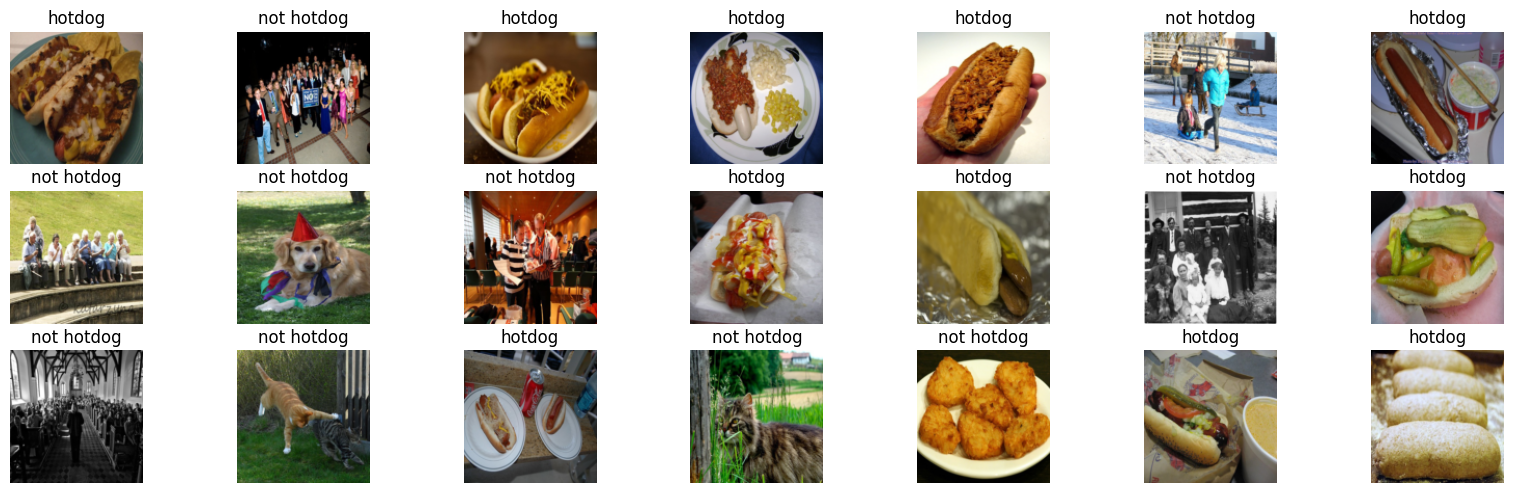

In [50]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

Now create a model and train it!


In [51]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(size**2 * 32 // 4 // 4, 500),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(500, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fully_connected(x)
        return x

model = Net()
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [52]:
num_epochs = 15

for epoch in tqdm(range(num_epochs), unit='epoch'):
    # For each epoch
    model.train()
    train_correct = 0

    for minibatch_no, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
        # Zero the gradients computed for each weight
        optimizer.zero_grad()
        
        # Forward pass your image through the network
        output = model(data)
        
        # Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #loss = criterion(output, target)
        
        # Backward pass through the network
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target == predicted).sum().cpu().item()

    # Compute the test accuracy
    model.eval()
    test_correct = 0
    
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target == predicted).sum().item()
    
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(train=100*train_acc, test=100*test_acc))

32it [00:04,  7.64it/s]00:00<?, ?epoch/s]
  7%|▋         | 1/15 [00:07<01:43,  7.40s/epoch]

Accuracy train: 64.7%	 test: 68.4%


32it [00:03,  8.20it/s]
 13%|█▎        | 2/15 [00:14<01:34,  7.30s/epoch]

Accuracy train: 74.4%	 test: 73.6%


32it [00:04,  7.46it/s]
 20%|██        | 3/15 [00:22<01:29,  7.47s/epoch]

Accuracy train: 78.7%	 test: 73.6%


32it [00:04,  7.47it/s]
 27%|██▋       | 4/15 [00:29<01:22,  7.53s/epoch]

Accuracy train: 81.8%	 test: 73.5%


32it [00:04,  7.31it/s]
 33%|███▎      | 5/15 [00:37<01:15,  7.58s/epoch]

Accuracy train: 86.3%	 test: 67.1%


32it [00:04,  7.52it/s]
 40%|████      | 6/15 [00:45<01:07,  7.54s/epoch]

Accuracy train: 87.3%	 test: 74.1%


32it [00:04,  7.55it/s]
 47%|████▋     | 7/15 [00:52<01:00,  7.52s/epoch]

Accuracy train: 91.3%	 test: 73.6%


32it [00:04,  7.43it/s]
 53%|█████▎    | 8/15 [01:00<00:52,  7.56s/epoch]

Accuracy train: 93.9%	 test: 72.7%


32it [00:04,  7.43it/s]
 60%|██████    | 9/15 [01:07<00:45,  7.56s/epoch]

Accuracy train: 95.5%	 test: 73.5%


32it [00:04,  7.57it/s]
 67%|██████▋   | 10/15 [01:15<00:37,  7.54s/epoch]

Accuracy train: 97.2%	 test: 72.9%


32it [00:04,  7.39it/s]
 73%|███████▎  | 11/15 [01:22<00:30,  7.55s/epoch]

Accuracy train: 98.2%	 test: 73.4%


32it [00:04,  7.51it/s]
 80%|████████  | 12/15 [01:30<00:22,  7.55s/epoch]

Accuracy train: 97.9%	 test: 74.4%


32it [00:04,  7.49it/s]
 87%|████████▋ | 13/15 [01:37<00:15,  7.54s/epoch]

Accuracy train: 98.2%	 test: 72.7%


32it [00:04,  7.22it/s]
 93%|█████████▎| 14/15 [01:45<00:07,  7.66s/epoch]

Accuracy train: 98.8%	 test: 72.1%


32it [00:04,  7.29it/s]
100%|██████████| 15/15 [01:53<00:00,  7.57s/epoch]

Accuracy train: 98.3%	 test: 71.4%


In [53]:
# Save the model
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/hotdog_not_hotdog_model.pth')